## Notebook for spike sorting from .kwd data using the Pipeline of mountainsort (linux channel has pipeline)
Uses:
    - intan2kwik (https://github.com/zekearneodo/intan2kwik/blob/master/README.md)
    - mountainlab suite(https://github.com/flatironinstitute/mountainlab-js)
    - mountainsort https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md
    - mountainsort examples https://github.com/flatironinstitute/mountainsort_examples/blob/master/README.md

In [1]:
import socket
import os
import glob
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
from importlib import reload

# pipeline imports
from pipefinch.neural.convert import intan
from pipefinch.neural.sort.mountain import core as msc
from intan2kwik import kwd

#mountainsort imports (for sorting)
import mountainlab_pytools.mlproc as mlp

import logging

# Setup the logger
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
ch.setFormatter(formatter)
logger.addHandler(ch)
        
logger.info('Logger set')
logger.info('Hostname {}'.format(socket.gethostname()))

2019-02-06 10:29:33,131 - root - INFO - Logger set
2019-02-06 10:29:33,132 - root - INFO - Hostname lookfar


### functions and definitions to prepare the file structure

In [2]:
locations_dict = {};
locations_dict['zebra'] = {'mnt': os.path.abspath('/data/experiment'),
                  'local': os.path.abspath('/data/experiment')}
locations_dict['ZOROASTRO'] = {'mnt': os.path.abspath('B:\microdrive\data'),
                  'local': os.path.abspath('D:\microdrive')}
locations_dict['lookfar'] = {'mnt': os.path.abspath('/Users/zeke/experiment'),
                  'local': os.path.abspath('/Users/zeke/experiment')}

def get_exp_struct_from_hostname():
    hostname = socket.gethostname()
    return locations_dict[hostname]

def get_exp_struct():
    # get the configuration of the experiment:
    # if environment variable 'EXPERIMENT_PATH' exists, 
    # read 'EXPERIMENT_PATH/config/expstruct.json'
    exp_struct = dict()
    read_exp_base = os.environ.get('EXPERIMENT_PATH')
    if read_exp_base is not None:
        # if there is a .json file configured with the variables of the experiment
        exp_base = os.path.abspath(read_exp_base)
        exp_struct_json_path = os.path.join(exp_base, 'exp_struct.json')
        exp_struct = read_json_exp_struct()
    else:
        # try to read it from the hostname
        exp_struct = get_exp_struct_from_hostname()
    
    # make the exp struct dict.
    # Todo: said
    
    return exp_struct

### Session parameters and raw files

In [3]:
# sess_par = {'bird': 'o3g3',
#            'sess': 'awake_mix_test',
#             'neural': 'neural'}

# for testing triggers from recorder
sess_par = {'bird': 'p14r14',
           'sess': '2019-02-04_0000_02',
            'neural': 'ephys'}

def get_file_structure(sess_par: dict):
    exp_struct = get_exp_struct()
    
    exp_struct['raw_folder'] = os.path.join(exp_struct['mnt'], sess_par['bird'], sess_par['neural'], sess_par['sess'])
    exp_struct['ss_folder'] = os.path.join(exp_struct['local'], sess_par['bird'], 'ss_data', sess_par['sess'])
    return exp_struct

file_struct = get_file_structure(sess_par)

logger.info('Raw folder {}'.format(file_struct['raw_folder']))

#list all the files in the session
#glob.glob(os.path.join(raw_folder, '*.rhd'))

2019-02-06 10:29:41,556 - root - INFO - Raw folder /Users/zeke/experiment/p14r14/ephys/2019-02-04_0000_02


### convert the whole session to a .kwd file
Conversion sends every .rhd file in the folder to a rec in the .kwd file (experiment.kwd in the session ss folder)
All of the files and all of the channels are converted; filtering and subselection of sub-epochs and channels occurs later.
The .kwd is raw data, only in a friendlier format.


In [4]:
reload(kwd)
## Convert the whole session to a kwd file
ss_folder = file_struct['ss_folder']
raw_folder = file_struct['raw_folder']
kwd_path = os.path.join(ss_folder, 'experiment.kwd')
bin_path = os.path.join(ss_folder, 'experiment.bin')
os.makedirs(ss_folder, exist_ok=True)
#first_intan_hdr, sess_pd = kwd.intan_to_kwd(raw_folder, kwd_path)

## revisit reading a dataset

In [5]:
import h5py
from pipefinch.h5tools.core import tables
from pipefinch.h5tools.kwik import kwdfunctions as kwdf
from pipefinch.h5tools.kwik import kutil

In [6]:
kwd_file = h5py.File(kwd_path, 'r')
dataset = kwd_file['/recordings/0/data']
print(dataset)
kwd_file.close()

<HDF5 dataset "data": shape (5999760, 3), type "<i2">


In [7]:
all_dset = dataset.read_direct

## reading events

In [8]:
from pipefinch.h5tools.kwik import event as ev

In [9]:
reload(ev)
kwd_file = h5py.File(kwd_path, 'r')

ttl = ev.TTL('ttl', 'DIN', kwd_file)
ttl.event_pd.head()

,rec,edge,ch_idx,t,ch
0,0,1,0,288689,DIN-00
1,0,0,0,298689,DIN-00
2,0,1,0,318850,DIN-00
3,0,0,0,328850,DIN-00
4,0,1,0,370851,DIN-00


In [108]:
pd_meta = kwdf.get_all_rec_meta(kwd_path)
pd_meta.head()

,bit_depth,name,sample_rate,start_sample,start_time,channel_bit_volts,channel_names,channels_sample_rate,dig_channel_names,is_multiSampleRate_data,valid_samples,samples_count
0,16,0,20000.0,0,2019-02-04 11:26:02,"[0.195, 0.195, 5.0354e-05]","[D-000, D-027, ADC-00]","[20000.0, 20000.0, 20000.0]","[DIN-00, DIN-01]",0,"[5999760.0, 5999760.0, 5999760.0]",5999760
1,16,1,20000.0,0,2019-02-04 11:30:45,"[0.195, 0.195, 5.0354e-05]","[D-000, D-027, ADC-00]","[20000.0, 20000.0, 20000.0]","[DIN-00, DIN-01]",0,"[6000480.0, 6000480.0, 6000480.0]",6000480
2,16,2,20000.0,0,2019-02-04 16:00:53,"[0.195, 0.195, 5.0354e-05]","[D-000, D-027, ADC-00]","[20000.0, 20000.0, 20000.0]","[DIN-00, DIN-01]",0,"[115987680.0, 115987680.0, 115987680.0]",115987680
3,16,3,20000.0,0,2019-02-04 17:37:34,"[0.195, 0.195, 5.0354e-05]","[D-000, D-027, ADC-00]","[20000.0, 20000.0, 20000.0]","[DIN-00, DIN-01]",0,"[2635200.0, 2635200.0, 2635200.0]",2635200
4,16,4,20000.0,0,2019-02-04 17:40:51,"[0.195, 0.195, 5.0354e-05]","[D-000, D-027, ADC-00]","[20000.0, 20000.0, 20000.0]","[DIN-00, DIN-01]",0,"[5999760.0, 5999760.0, 5999760.0]",5999760


### align with events

In [10]:
# get all the frames around a trigger for a dataset
reload(kwdf)
ch_name = 'DIN-01'
edge = 1

pd_meta = kwdf.get_all_rec_meta(kwd_path)

# Select channels:
wanted_chans = np.array(['ADC'])

#in this case, that's all the channels

sel_chan_names = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)

pre_samples = -15000
post_samples = 15000
span = post_samples - pre_samples


ttl = ev.TTL('ttl', 'DIN', kwd_file)
ttl.event_pd.set_index(['ch', 'edge'], inplace=True)

# collect the frames

# go through the recs
ttl_event_pd = ttl.event_pd.loc[ch_name].loc[edge]
all_rec = np.unique(ttl_event_pd['rec'].values)

all_rec_frames = []
for r in all_rec:
    chan_list = kwdf.rec_chan_idx(pd_meta, r, sel_chan_names)
    t_events_rec = ttl_event_pd[ttl_event_pd['rec']==r]['t'].values
    t_events_rec.sort()
#     for x in t_events_rec:
#         arr = kwdf.get_data_chunk(kwd_file, r, x + pre_samples, span, chan_list)
#         logger.info(arr.shape)
    frames = list(map(lambda x: kwdf.get_data_chunk(kwd_file, r, x + pre_samples, span, chan_list), t_events_rec))
    ## TODO: make get_data_chunk pad with nans.
    all_rec_frames.append(np.stack(frames, axis=0))

all_frames_array = np.concatenate(all_rec_frames, axis=0)


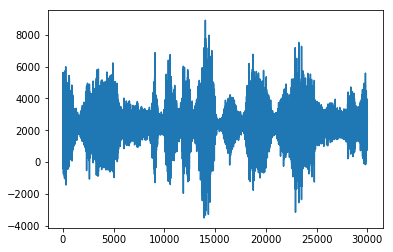

In [12]:
plt.plot(np.nanmean(all_frames_array, axis=0))

In [13]:
all_frames_array.shape

(79, 30000, 1)

In [14]:
# get all spectrograms
from scipy import signal as sg

def plot_spectrogram(x, before_ms, after_ms, s_f, n_window=512, n_overlap=None, sigma=None, ax=None, **kwargs):
    if n_overlap is None:
        n_overlap = int(n_window*0.75)
    if sigma is None:
        sigma = 1 / 200. * s_f

    # Make the spectrogram
    f, t, Sxx = sg.spectrogram(x, s_f, nperseg=n_window, noverlap=n_overlap, window=sg.gaussian(n_window, sigma),
                            scaling='spectrum')

    Sxx[[Sxx < np.max((Sxx) * 0.000055)]] = 1

    span_before = np.zeros((Sxx.shape[0], np.int(before_ms / 1000. * s_f)))
    span_after = np.zeros((Sxx.shape[0], np.int(after_ms / 1000. * s_f) + x.size - Sxx.shape[1]))
    span_before[:] = np.nan
    span_after[:] = np.nan
    # Sxx = np.hstack((span_before, (Sxx), span_after))

    #if ax is None:
        #spec_fig, ax = plt.subplots()
        #ax = spec_fig.add_axes([0, 0, 1, 1])

    #ax.pcolormesh(((t - 0.5 * n_window / s_f) * 1000.), f, np.log(Sxx), rasterized=True, cmap='inferno')
    #ax.set_xlim(-before_ms, after_ms + int(x.size / s_f * 1000.))
    #ax.set_ylim(0, 10000)
    #ax.imshow(np.log(Sxx[::-1]), aspect='auto', cmap='inferno', rasterized=True)
    # ax.plot((span_before.shape[1], span_before.shape[1]), (np.min(f), np.max(f)), 'k--')
    return Sxx

sxx = plot_spectrogram(all_frames_array[62, :, 0], 0, 0, 20000);
sxx.shape

(257, 231)

(20046, 231)

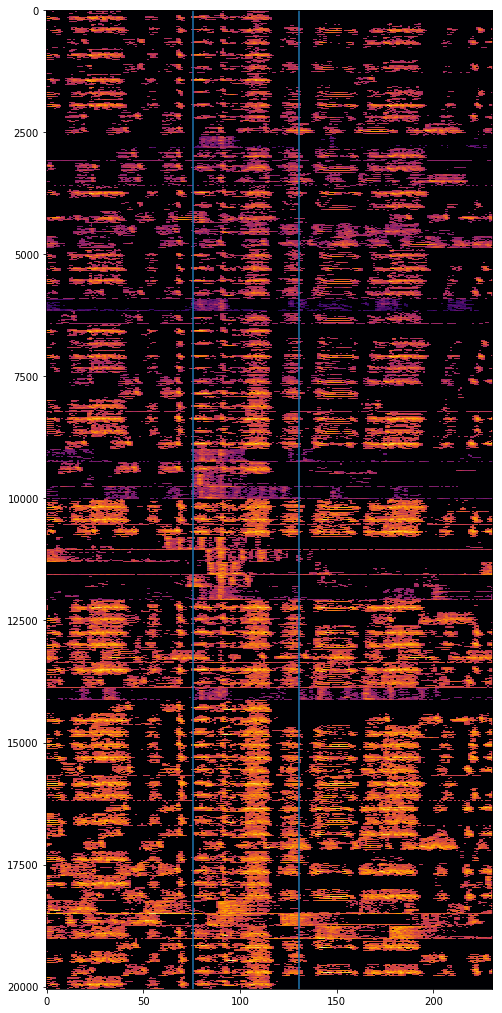

In [15]:
many_spec = [plot_spectrogram(all_frames_array[i, :, 0], 0, 0, 20000) for i in np.arange(1,79)];
spec_arr = np.vstack(many_spec)
fig, ax = plt.subplots(figsize=(8, 18))
mark = pre_samples/span * spec_arr.shape[1] * (-1)

ax.imshow(np.log(spec_arr[::-1]), aspect='auto', cmap='inferno')

ax.axvline(x=mark+15)
ax.axvline(x=mark-40)
spec_arr.shape

(20046, 231)

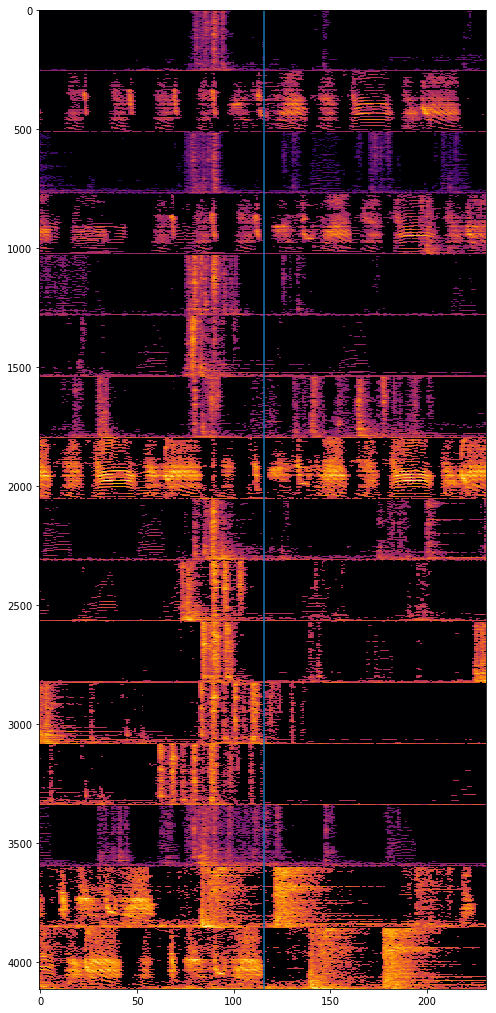

In [16]:
bad_ones = np.array([5, 6, 40, 36, 35, 34, 33, 32, 27, 24, 41, 43, 60, 55, 65, 68])
out_spec = [plot_spectrogram(all_frames_array[i, :, 0], 0, 0, 20000) for i in bad_ones];
out_spec_arr = np.vstack(out_spec)
fig, ax = plt.subplots(figsize=(8, 18))
mark = pre_samples/span * spec_arr.shape[1] * (-1)

ax.imshow(np.log(out_spec_arr[::-1]), aspect='auto', cmap='inferno')

ax.axvline(x=mark)
spec_arr.shape

### a quick look at the right/wrong triggers

In [18]:
import umap
from sklearn.datasets import load_digits

digits = load_digits()
digits.data.shape

(1797, 64)

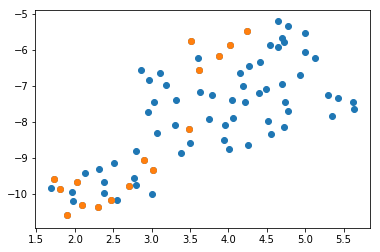

In [19]:
all_spec_flat = np.vstack([x[:, 115-50:115+25].flatten() for x in many_spec])
all_spec_flat.shape
embedding = umap.UMAP(n_neighbors=20,
                      min_dist=0.1,
                      metric='manhattan').fit_transform(all_spec_flat)
plt.scatter(
    embedding[:, 0], embedding[:, 1])
plt.scatter(embedding[bad_ones,0], embedding[bad_ones,1])

In [20]:
all_spec_flat.shape

(78, 19275)

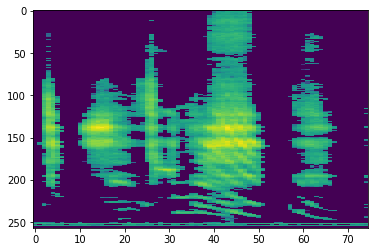

In [31]:
avg_spec = np.median(all_spec_flat, axis=0)
plt.imshow(np.log(avg_spec.reshape(257, -1)[::-1]), aspect='auto')

In [ ]:
plt.imshow(avg_spec.reshape(257, -1).T, aspect='auto')

In [516]:
outliers = np.where(embedding[:, 1]<0)[0]
outliers.shape

(20,)

In [598]:
## updating a kwik file

In [480]:
from intan2kwik.core.file import util as fu
from intan2kwik.kwd import which_board    

In [599]:
reload(kwdf)
_, nu_pd, _ = kwdf.update_kwd(other_kwd_path, raw_folder)

2019-02-05 16:58:08,003 - pipefinch.h5tools.kwik.kwdfunctions - INFO - updating kwd file /Users/zeke/experiment/p14r14/ss_data/2019-02-01_0000_01/experiment0.kwd from folder /Users/zeke/experiment/p14r14/ephys/2019-02-04_0000_02
2019-02-05 16:58:08,043 - pipefinch.h5tools.kwik.kwdfunctions - INFO - No new files to add to the file


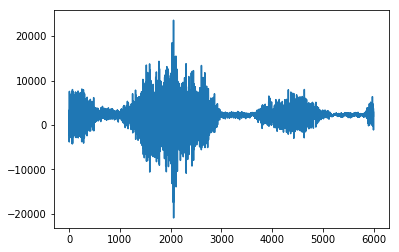

In [121]:
plt.plot(all_frames_array[61, :, 0])

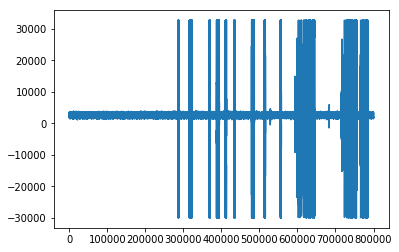

In [601]:
y = kwdf.get_data_chunk(kwd_file, 0, 0, 800000, chan_list)
plt.plot(y)

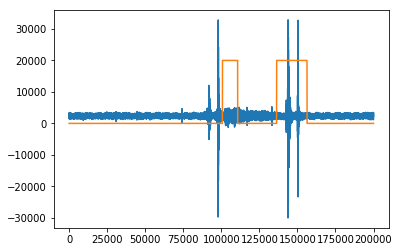

In [225]:
dset = kwd_file['/recordings/0/data']
digset = kwd_file['/recordings/0/dig_in']
plt.plot(dset[500000:700000, 2])
plt.plot(digset[500000:700000,0]*20000)

In [169]:
sel_chan_names

array(['ADC-00'], dtype='<U6')

In [165]:
ttl_event_pd.loc[0]['t'].values

array([ 600678,  636279,  746441, 1101888, 1911425, 2351514, 3456897])

In [150]:
ttl_event_pd.loc[0]['t'].apply(lambda x: kwdf.get_data_chunk(kwd_file, r, ))

,ch_idx
t,
600678,0
636279,0
746441,0
1101888,0
1911425,0
2351514,0
3456897,0


### what happens when attributes are lists of strings
(used while revisiting get_rec_attrs and h5_unicode_hack)

In [13]:
from pipefinch.h5tools.core import h5tools

In [14]:
attrs_path = '/recordings/0/application_data'
group_obj = kwd_file[attrs_path]

group_attrs = group_obj.attrs
#r_attrs = kwdf.get_rec_attrs()

reload(h5tools)
group_attrs_dict = h5tools.obj_attrs_2_dict_translator(group_obj)

ValueError: Not a location (invalid object ID)

### read all the meta of a kwd file into a pandas DataFrame

In [15]:
pd_meta.loc[pd_meta['name']==0, 'channel_names'].values

NameError: name 'pd_meta' is not defined

In [16]:
reload(kwdf)
pd_meta = kwdf.get_all_rec_meta(kwd_path)
pd_meta.head(5)


,bit_depth,name,sample_rate,start_sample,start_time,channel_bit_volts,channel_names,channels_sample_rate,dig_channel_names,is_multiSampleRate_data,valid_samples,samples_count
0,16,0,20000.0,0,2019-02-01 09:43:59,"[0.195, 0.195, 5.0354e-05]","[D-000, D-031, ADC-00]","[20000.0, 20000.0, 20000.0]","[DIN-00, DIN-01, DIN-12, DIN-13, DIN-14, DIN-15]",0,"[3599280.0, 3599280.0, 3599280.0]",3599280
1,16,1,20000.0,0,2019-02-01 09:46:29,"[0.195, 0.195, 5.0354e-05]","[D-000, D-031, ADC-00]","[20000.0, 20000.0, 20000.0]","[DIN-00, DIN-01, DIN-12, DIN-13, DIN-14, DIN-15]",0,"[4550400.0, 4550400.0, 4550400.0]",4550400
2,16,2,20000.0,0,2019-02-01 09:51:35,"[0.195, 0.195, 5.0354e-05]","[D-000, D-031, ADC-00]","[20000.0, 20000.0, 20000.0]","[DIN-00, DIN-01, DIN-12, DIN-13, DIN-14, DIN-15]",0,"[3011040.0, 3011040.0, 3011040.0]",3011040
3,16,3,20000.0,0,2019-02-01 09:53:37,"[0.195, 0.195, 5.0354e-05]","[D-000, D-031, ADC-00]","[20000.0, 20000.0, 20000.0]","[DIN-00, DIN-01, DIN-12, DIN-13, DIN-14, DIN-15]",0,"[3599280.0, 3599280.0, 3599280.0]",3599280
4,16,4,20000.0,0,2019-02-01 09:56:35,"[0.195, 0.195, 5.0354e-05]","[D-000, D-031, ADC-00]","[20000.0, 20000.0, 20000.0]","[DIN-00, DIN-01, DIN-12, DIN-13, DIN-14, DIN-15]",0,"[18444960.0, 18444960.0, 18444960.0]",18444960


# Dealing with digital channels

In [17]:
reload(kutil)
reload(kwdf)

<module 'pipefinch.h5tools.kwik.kwdfunctions' from '/Users/zeke/repos/pipefinch/pipefinch/h5tools/kwik/kwdfunctions.py'>

In [22]:
dig_chans = kwdf.get_all_chan_names(pd_meta, block='digital', chan_filt=np.array(['DIN']))
dig_chans

array(['DIN-00', 'DIN-01', 'DIN-12', 'DIN-13', 'DIN-14', 'DIN-15'],
      dtype='<U6')

In [29]:
dig_chans_l = np.array(list(map(lambda x: x.lower(), dig_chans)))

In [30]:
dig_chans_l

array(['din-00', 'din-01', 'din-12', 'din-13', 'din-14', 'din-15'],
      dtype='<U6')

In [31]:

ch_idx = kwdf.find_chan_names_idx( kwdf.get_all_chan_names(pd_meta, block='digital'), np.array(['DIN-00']))

In [38]:
assert ch_idx.size==1, 'Should have found 1 occurrence of ch {}, but found {}'.format('l', ch_idx.size)

AssertionError: Should have found 1 occurrence of ch l, but found 1

In [46]:
kwd_file = h5py.File(kwd_path, 'r')
dig_chunk = kwdf.get_data_chunk(kwd_file, 0, 0, 80000000, [0], table_name='dig_in')

In [41]:
pd_meta['name'].values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [61]:
all_dig_chunk = np.hstack([dig_chunk, np.roll(dig_chunk, 20)])

In [60]:
edge_ch = kwd_file['/recordings/10/dig_edge_ch']
edge_t = kwd_file['/recordings/10/dig_edge_t']
edge = kwd_file['/recordings/10/dig_edge']

In [77]:
ev_pd = pd.DataFrame(np.empty([0, 3]), columns=['ch_idx', 'edge', 't'])
ev_pd

,ch_idx,edge,t


In [83]:

ev_pd = pd.DataFrame(np.hstack([edge_ch, edge, edge_t]), columns=['ch_idx', 'edge', 't'])

In [84]:
ev_pd

,ch_idx,edge,t
0,0,1,49150
1,0,0,59150


In [78]:
ev_pd.append(pd.DataFrame(np.hstack([edge_ch, edge, edge_t]), columns=['ch_idx', 'edge', 't']))

,ch_idx,edge,t
0,0.0,1.0,49150.0
1,0.0,0.0,59150.0


In [85]:
ev_pd['ch'] = ev_pd['ch_idx'].apply(lambda x: dig_chans[x])

In [86]:
ev_pd

,ch_idx,edge,t,ch
0,0,1,49150,DIN-00
1,0,0,59150,DIN-00


In [53]:
kwd_file['/recordings/10/dig_edge_ch'][:]==0

array([[ True],
       [ True]])

In [98]:
def get_edges(data_chunk):
    hi = np.argwhere(np.diff(data_chunk, axis=0)==1)
    lo = np.argwhere(np.diff(data_chunk, axis=0)==-1)
    
    [hi, lo] = [np.hstack([x, np.reshape(np.ones(x.shape[0])*edge, [-1, 1])]) for x, edge in zip([hi, lo], [1, 0])]
    
    hi_lo = np.vstack([hi, lo]).astype(np.int)
    hi_lo[np.argsort(hi_lo[:, 0])]
    return hi_lo

hilo = get_edges(all_dig_chunk)

In [102]:
np.argsort(hilo[:, 0])

array([ 0,  1, 22, 23,  2,  3, 24, 25,  4,  5, 26, 27,  6,  7, 28, 29,  8,
        9, 30, 31, 10, 11, 32, 33, 12, 13, 34, 35, 14, 15, 36, 37, 16, 17,
       38, 39, 18, 19, 40, 41, 20, 21, 42, 43])

In [14]:
# get a digital channel

kwd_file = h5py.File(kwd_path, 'r')
dataset = kwd_file['/recordings/0/dig_in']
print(dataset)
#kwd_file.close()

<HDF5 dataset "dig_in": shape (12000240, 1), type "<i2">


In [18]:
kwd_file.close()

In [26]:
with h5py.File(kwd_path, 'r') as kwd_file:
    dig_stream = kwdf.get_data_chunk(kwd_file, 0, 0, 1000000, np.array([0]), table_name='dig_in')
np.where(dig_stream==1)

(array([391385, 391386, 391387, ..., 515785, 515786, 515787]),
 array([0, 0, 0, ..., 0, 0, 0]))

### Kwd file to mda 

## Select a subset of a kwd file:
 - a set of recordings (e.g, by range of time)
 - a set of channels (by identifier) (e.g: a whole port from the intan, like 'A-', or the channel where the mic is, like 'ADC-00')

In [17]:
np.unique(np.hstack(pd_meta.loc[:, 'channel_names'].values))

array(['A-001', 'A-002', 'A-003', 'A-004', 'A-006', 'A-008', 'A-010',
       'A-012', 'A-013', 'A-014', 'A-017', 'A-019', 'A-021', 'A-022',
       'A-023', 'A-026', 'A-028', 'ADC-00'], dtype='<U6')

In [18]:
reload(kwdf)
pd_meta = kwdf.get_all_rec_meta(kwd_path)

# Select channels:
wanted_chans = np.array(['A-', 'ADC'])

all_chan_names = kwdf.get_all_chan_names(pd_meta)

sel_chan_names = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)

#in this case, that's all the channels
sel_chan_names

array(['A-001', 'A-002', 'A-003', 'A-004', 'A-006', 'A-008', 'A-010',
       'A-012', 'A-013', 'A-014', 'A-017', 'A-019', 'A-021', 'A-022',
       'A-023', 'A-026', 'A-028', 'ADC-00'], dtype='<U6')

In [166]:
wanted_chans = np.array(['A-']) # all ephys channels
chan_list = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)

NameError: name 'pd_meta' is not defined

## Make .mda file with a set of recordings in a session
 - pick all in port A
 - get all rec within a time range


In [108]:
reload(kwdf)
reload(kutil)
ch.setLevel(logging.INFO)

all_rec_list = kutil.get_rec_list(kwd_path)
all_rec_list

wanted_chans = np.array(['ADC-00']) # all ephys channels
chan_list = kwdf.get_all_chan_names(pd_meta, chan_filt=wanted_chans)

bin_path = os.path.join(ss_folder, 'experiment.bin')
bin_file = kwdf.kwd_to_binary(kwd_path, bin_path, chan_list=np.array(['ADC-00']), rec_list=np.array([0, 1, 2]), header='mda')
rec_attr_dict = kwdf.get_rec_attrs(kwd_path, 0)
all_rec_meta_pd = kwdf.get_all_rec_meta(kwd_path)

2018-12-24 23:05:55,663 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Writing kwd_file /data/experiment/raw_data/o3g3/ss_data/awake_mix_test/experiment.kwd to binary
2018-12-24 23:05:55,671 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Channels to extract: ['ADC-00']
2018-12-24 23:05:55,672 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Will go through recs [0 1 2]
2018-12-24 23:05:55,672 - pipefinch.h5tools.kwik.kwdfunctions - INFO - Creating binary file /data/experiment/raw_data/o3g3/ss_data/awake_mix_test/experiment.bin


2018-12-24 23:05:55,720 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/0
2018-12-24 23:05:55,951 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/1
2018-12-24 23:05:56,384 - pipefinch.h5tools.core.tables - INFO - Ripping dataset from /recordings/2
2018-12-24 23:05:57,140 - pipefinch.h5tools.kwik.kwdfunctions - INFO - 60001200 elements written


In [97]:
rec_chans = pd_meta.loc[pd_meta['name']==0, 'channel_names'].values
kwdf.find_chan_names_idx(rec_chans[0], chan_list)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),)

#### test that the mda was written ok by looking at the microphone channel

In [15]:
from mountainlab_pytools import mdaio
loaded_mda = mdaio.readmda(bin_path)

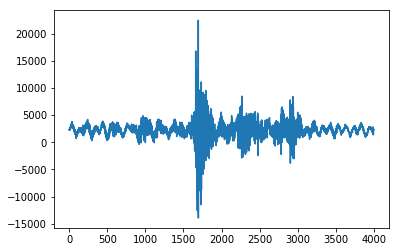

In [16]:
start = 8400000 + 30000
end = start + 4000
plt.plot(loaded_mda[:, start:end].T);

### tyr to fix the channel namimg

In [55]:
all_rec_meta_pd.head()

,bit_depth,sample_rate,name,start_sample,start_time,is_multiSampleRate_data,channels_sample_rate,channel_bit_volts,channel_names,valid_samples,samples_count
0,16,20000.0,0,0,0018-09-08 14:34:46,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'A-001', b'A-002', b'A-003', b'A-004', b'A-0...","[12000240.0, 12000240.0, 12000240.0, 12000240....",12000240
1,16,20000.0,1,0,0018-09-08 18:55:37,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'A-001', b'A-002', b'A-003', b'A-004', b'A-0...","[24000480.0, 24000480.0, 24000480.0, 24000480....",24000480
2,16,20000.0,2,0,0018-09-08 19:15:38,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'A-001', b'A-002', b'A-003', b'A-004', b'A-0...","[24000480.0, 24000480.0, 24000480.0, 24000480....",24000480


In [17]:
all_rec_meta_pd.loc[0, 'channel_names']

array([b'A-001', b'A-002', b'A-003', b'A-004', b'A-006', b'A-008',
       b'A-010', b'A-012', b'A-013', b'A-014', b'A-017', b'A-019',
       b'A-021', b'A-022', b'A-023', b'A-026', b'A-028', b'ADC-00'],
      dtype='|S6')

In [18]:
from pipefinch.h5tools.core import h5tools

kwd_file = h5py.File(kwd_path, 'r')

for k, v in kwd_file['/recordings/0/application_data'].attrs.items():
    print(k)

is_multiSampleRate_data
channels_sample_rate
channel_bit_volts
channel_names


In [19]:
kwd_file['/recordings/0'].attrs['start_time']

b'18-09-08 14:34:46'

In [26]:
kwd_file['/recordings/0/application_data'].attrs['is_multiSampleRate_data'].dtype

dtype('int64')

In [24]:
kwd_file['/recordings/0/application_data'].attrs['channel_names'].dtype

dtype('S6')

In [265]:
pd_slice = apd['name'].isin(np.array([0, 5, 7]))
apd.loc[pd_slice]

,bit_depth,sample_rate,name,start_sample,start_time,is_multiSampleRate_data,channels_sample_rate,channel_bit_volts,channel_names,valid_samples,channel_names_diff
0,16,20000.0,0,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[14556240.0, 14556240.0, 14556240.0, 14556240....",False
5,16,20000.0,5,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[207360.0, 207360.0, 207360.0, 207360.0, 20736...","[True, True, True, True, True, True, True, Tru..."
7,16,20000.0,7,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[774720.0, 774720.0, 774720.0, 774720.0, 77472...","[True, True, True, True, True, True, True, Tru..."


In [274]:
cmplist = diff_arrays(apd, 'channel_names')
cmp_arr = np.stack(cmplist[1:])
cmp_arr.all(axis=1)

/home/zinch/conda/envs/msort/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [278]:
apd.head()

,bit_depth,sample_rate,name,start_sample,start_time,is_multiSampleRate_data,channels_sample_rate,channel_bit_volts,channel_names,valid_samples,channel_names_diff
0,16,20000.0,0,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[14556240.0, 14556240.0, 14556240.0, 14556240....",False
1,16,20000.0,1,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[106560.0, 106560.0, 106560.0, 106560.0, 10656...","[True, True, True, True, True, True, True, Tru..."
2,16,20000.0,2,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[1199520.0, 1199520.0, 1199520.0, 1199520.0, 1...","[True, True, True, True, True, True, True, Tru..."
3,16,20000.0,3,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[308160.0, 308160.0, 308160.0, 308160.0, 30816...","[True, True, True, True, True, True, True, Tru..."
4,16,20000.0,4,0,1,0,"[20000.0, 20000.0, 20000.0, 20000.0, 20000.0, ...","[0.195, 0.195, 0.195, 0.195, 0.195, 0.195, 0.1...","[b'D-004', b'D-006', b'D-008', b'D-012', b'D-0...","[1199520.0, 1199520.0, 1199520.0, 1199520.0, 1...","[True, True, True, True, True, True, True, Tru..."


In [277]:
cmp_arr.shape

(186, 14)

In [135]:
rec_attr_dict['app_data']['channel_names'][:10]

array([b'D-004', b'D-006', b'D-008', b'D-012', b'D-019', b'D-022',
       b'D-023', b'D-024', b'D-025', b'D-026'], dtype='|S6')

In [ ]:
def 

## Scripts for sorting

### prep the files with their nice formats, locations and names


In [142]:
rhd_list

NameError: name 'rhd_list' is not defined

In [143]:
ss_folder = os.path.join(exp_base, sess_par['bird'], 'ss_data', sess_par['sess'])

file_paths, out_folder = msc.make_paths(ss_folder)
os.makedirs(ss_folder, exist_ok=True)
#todo:
# meta and pars from intan files et al
s_f = 20000

# parameters to pass to the msort scripts
ds_params = {'samplerate': s_f,
            'detect_sign': -1}

with open(file_paths['params'], 'w') as fp:
    json.dump(ds_params, fp)
    logger.info('Created session par files {}'.format(file_paths['params']))
    
# create the mda file from the rhd_list
#intan_meta, samples_in = intan.intan_to_bin(rhd_list[:], file_paths['mda'], variant='mda');


2018-12-18 18:33:33,063 - root - INFO - Created session par files /home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/params.json


In [144]:
ds_params

{'samplerate': 20000, 'detect_sign': -1}

In [145]:
file_paths

{'mda': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/raw.mda',
 'params': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/params.json',
 'geom': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/geom.csv',
 'filt': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/sort_out/filt.mda.prv',
 'pre': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/sort_out/pre.mda.prv',
 'firings': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/sort_out/firings.mda',
 'firings_curated': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/sort_out/firings_curated.mda',
 'cluster_metrics': '/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/sort_out/cluster_metrics.json'}

In [146]:
# test mountainsort method for reading sorting parameters
msc.read_dataset_params(ss_folder)

{'samplerate': 20000, 'detect_sign': -1}

In [147]:
# Initialize a pipeline
from mountainlab_pytools import mlproc as mlp
Pipeline=mlp.initPipeline();

JSProxyWidget(status='Not yet rendered')

In [148]:
msc.sort_dataset?

Signature: msc.sort_dataset(*, file_paths:dict, freq_min:int=300, freq_max:int=6000, adjacency_radius:int=1, detect_threshold:float=3, dispatch_method:str='run', opts:dict={})
Docstring: <no docstring>
File:      ~/repos/pipefinch/pipefinch/neural/sort/mountain/core.py
Type:      function


In [149]:
output_dir = os.path.join(ss_folder, 'sort_out');
# Pipeline was failing, need to debug this ('NameError: name 'widgets' is not defined')
# with Pipeline:
#     msc.sort_dataset(file_paths=file_paths, adjacency_radius=-1, detect_threshold=3, dispatch_method='add')

msc.sort_dataset(file_paths=file_paths, adjacency_radius=-1, detect_threshold=2, freq_min=600);

2018-12-18 18:33:33,152 - pipefinch.sort.mountain.comre - INFO - Bandpass filter


RUNNING: ml-run-process ephys.bandpass_filter --inputs timeseries:/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/raw.mda --parameters freq_max:6000 freq_min:600 samplerate:20000 --outputs timeseries_out:/home/zinch/data/o9j9/ss_data/20181125_r021_saveontrigger/sort_out/filt.mda.prv


KeyboardInterrupt: 

In [ ]:
file_paths

## Command for viewing:
 - open up terminal with the environment msort
 - go go the ss_data folder for the session
 - run the command: qt-mountainview --raw raw.mda --filt sort_out/filt.mda.prv --pre sort_out/pre.mda.prv --samplerate=20000 --firings sort_out/firings.mda --cluster_metrics sort_out/cluster_metrics.json